# Attack and Resilience

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import glob
import numpy as np
import pickle 
import statistics as st
import seaborn as sb
import random as rd

# Open Networks

In [2]:
networks={}

df = pd.read_csv('inputs/HPRD.tsv',sep='\t',names=['Source','Target'])
networks['HPRD'] = nx.from_pandas_edgelist(df,source='Source',target='Target')
networks['HPRD'].name = 'HPRD'
print(nx.info(networks['HPRD']),end='\n\n')

df = pd.read_csv('inputs/HINT.tsv',sep='\t',names=['Source','Target'])
networks['HINT'] = nx.from_pandas_edgelist(df,source='Source',target='Target')
networks['HINT'].name = 'HINT'
print(nx.info(networks['HINT']),end='\n\n')

networks['MINT']=nx.from_pandas_edgelist(pd.read_csv('inputs/MINT.txt',sep='\t',usecols=[0,1],header=None),source=0,target=1)
networks['MINT'].name='MINT'
print(nx.info(networks['MINT']),end='\n\n')

df = pd.read_csv("inputs/Reactome2019_FIsInGene_020720_with_annotations.txt",sep='\t')
networks['ReactomeFI'] = nx.from_pandas_edgelist(df,source='Gene1',target='Gene2')
networks['ReactomeFI'].name = 'Reactome'
print(nx.info(networks['ReactomeFI']),end='\n\n')

networks['Collaboration']=nx.read_edgelist('inputs/collaboration.edgelist.txt')
networks['Collaboration'].name='Collaboration'
print(nx.info(networks['Collaboration']),end='\n\n')

networks['Powergrid']=nx.read_edgelist('inputs/powergrid.edgelist.txt')
networks['Powergrid'].name='Powergrid'
print(nx.info(networks['Powergrid']),end='\n\n')

networks['Erdos-Renyi']=nx.read_gml('inputs/erdos_renyi.gml')
networks['Erdos-Renyi'].name='Erdos-Renyi'
print(nx.info(networks['Erdos-Renyi']),end='\n\n')

networks['Barabasi-Albert']=nx.read_gml('inputs/barabasi_albert_m2.gml')
networks['Barabasi-Albert'].name='Barabasi-Albert'
print(nx.info(networks['Barabasi-Albert']),end='\n\n')

Name: HPRD
Type: Graph
Number of nodes: 9465
Number of edges: 37039
Average degree:   7.8265

Name: HINT
Type: Graph
Number of nodes: 12543
Number of edges: 62590
Average degree:   9.9801

Name: MINT
Type: Graph
Number of nodes: 13363
Number of edges: 45924
Average degree:   6.8733

Name: Reactome
Type: Graph
Number of nodes: 14071
Number of edges: 268857
Average degree:  38.2143

Name: Collaboration
Type: Graph
Number of nodes: 23133
Number of edges: 93439
Average degree:   8.0784

Name: Powergrid
Type: Graph
Number of nodes: 4941
Number of edges: 6594
Average degree:   2.6691

Name: Erdos-Renyi
Type: Graph
Number of nodes: 10000
Number of edges: 13392
Average degree:   2.6784

Name: Barabasi-Albert
Type: Graph
Number of nodes: 10000
Number of edges: 69951
Average degree:  13.9902



# Attack Function

In [3]:
def getErroSTD(mr):
    #Calculate the variance.
    results=[r[1] for r in mr]
    resultsVariance=[]
    #results is a matriz. Each line is a repetion that contains 'howMany' values
    #The columns in this matriz are the values found in a point in time (f). So we the variance for each point 
    numberOfColumns = len(results[0])
    for col in range(numberOfColumns):
        colValues=[]
        for line in results:
            colValues.append(line[col])
        resultsVariance.append(np.std(colValues))   
    return resultsVariance

def rd_impact(G_original,repeat):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]
        listOfNode = list(G.nodes)
        rd.shuffle(listOfNode)#Randomize the nodes
        for i,_ in enumerate(range(len(listOfNode))):
            G.remove_node(listOfNode[i])
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)
            
        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])
        
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)    
    
    error=getErroSTD(matrizOfResults)
    plt.errorbar(xAxis,y,label='Random', yerr=error, ecolor='lightgreen', elinewidth=2, capsize=0,fmt='-',color='limegreen',linewidth=2)
    return matrizOfResults
  
def intentional_impact(G_original,repeat):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]

        #verticesOrdenados is a list of tuples (verticeName,degree)
        verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
        #In case two or more hubs have the same degree
        first=verticesOrdenados[0]
        equalsToFirst=[first[0]]
        cont=1
        while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
            equalsToFirst.append(verticesOrdenados[cont][0])
            cont+=1
        #randomize the list of hubs that have the same degree
        rd.shuffle(equalsToFirst)
        verticeToRemove=equalsToFirst[0]

        for step in range(Nstart):    
            G.remove_node(verticeToRemove)
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)

            #verticesOrdenados is a list of tuples (verticeName,degree)
            verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
            #In case two or more hubs have the same degree
            if(len(verticesOrdenados)>0):
                first=verticesOrdenados[0]
                equalsToFirst=[first[0]]
                cont=1
                while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
                    equalsToFirst.append(verticesOrdenados[cont][0])
                    cont+=1
                #randomize the list of hubs that have the same degree
                rd.shuffle(equalsToFirst)
                verticeToRemove=equalsToFirst[0]


        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])

    #Calculate the average of all repeat
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)
    
    #Calculate de error and plotIT
    error=getErroSTD(matrizOfResults)

    plt.errorbar(xAxis,y,label='Hubs', yerr=error, ecolor='skyblue', elinewidth=2, capsize=0,fmt='-',color='blue',linewidth=2)
    
    return matrizOfResults

def intentional_impact_degreeCluster(G_original,repeat):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]
        
        cluster = nx.clustering(G)
        degree = nx.degree(G)
        degreeAntiCluster={}
        for node in cluster:
            d=degree[node]
            c=cluster[node]
            dc=d*c
            degreeAntiCluster[node]=dc
        #verticesOrdenados is a list of tuples (verticeName,degree)
        verticesOrdenados = list(dict(sorted(degreeAntiCluster.items(), key=lambda x:x[1],reverse=True)).items())
        #In case two or more hubs have the same degree
        first=verticesOrdenados[0]
        equalsToFirst=[first[0]]
        cont=1
        while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
            equalsToFirst.append(verticesOrdenados[cont][0])
            cont+=1
        #randomize the list of hubs that have the same degree
        rd.shuffle(equalsToFirst)
        verticeToRemove=equalsToFirst[0]

        for step in range(Nstart):    
            G.remove_node(verticeToRemove)
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)

            #verticesOrdenados is a list of tuples (verticeName,degree)
            verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
            #In case two or more hubs have the same degree
            if(len(verticesOrdenados)>0):
                first=verticesOrdenados[0]
                equalsToFirst=[first[0]]
                cont=1
                while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
                    equalsToFirst.append(verticesOrdenados[cont][0])
                    cont+=1
                #randomize the list of hubs that have the same degree
                rd.shuffle(equalsToFirst)
                verticeToRemove=equalsToFirst[0]


        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])

    #Calculate the average of all repeat
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)
    
    #Calculate de error and plotIT
    error=getErroSTD(matrizOfResults)

    plt.errorbar(xAxis,y,label='Degree * Cluster', yerr=error, ecolor='red', elinewidth=2, capsize=0,fmt='-',color='tomato',linewidth=2)
    
    return matrizOfResults

HPRD Random
HPRD Hubs
HINT Random
HINT Hubs
MINT Random
MINT Hubs
ReactomeFI Random
ReactomeFI Hubs
Collaboration Random
Collaboration Hubs
Powergrid Random
Powergrid Hubs
Erdos-Renyi Random
Erdos-Renyi Hubs
Barabasi-Albert Random
Barabasi-Albert Hubs


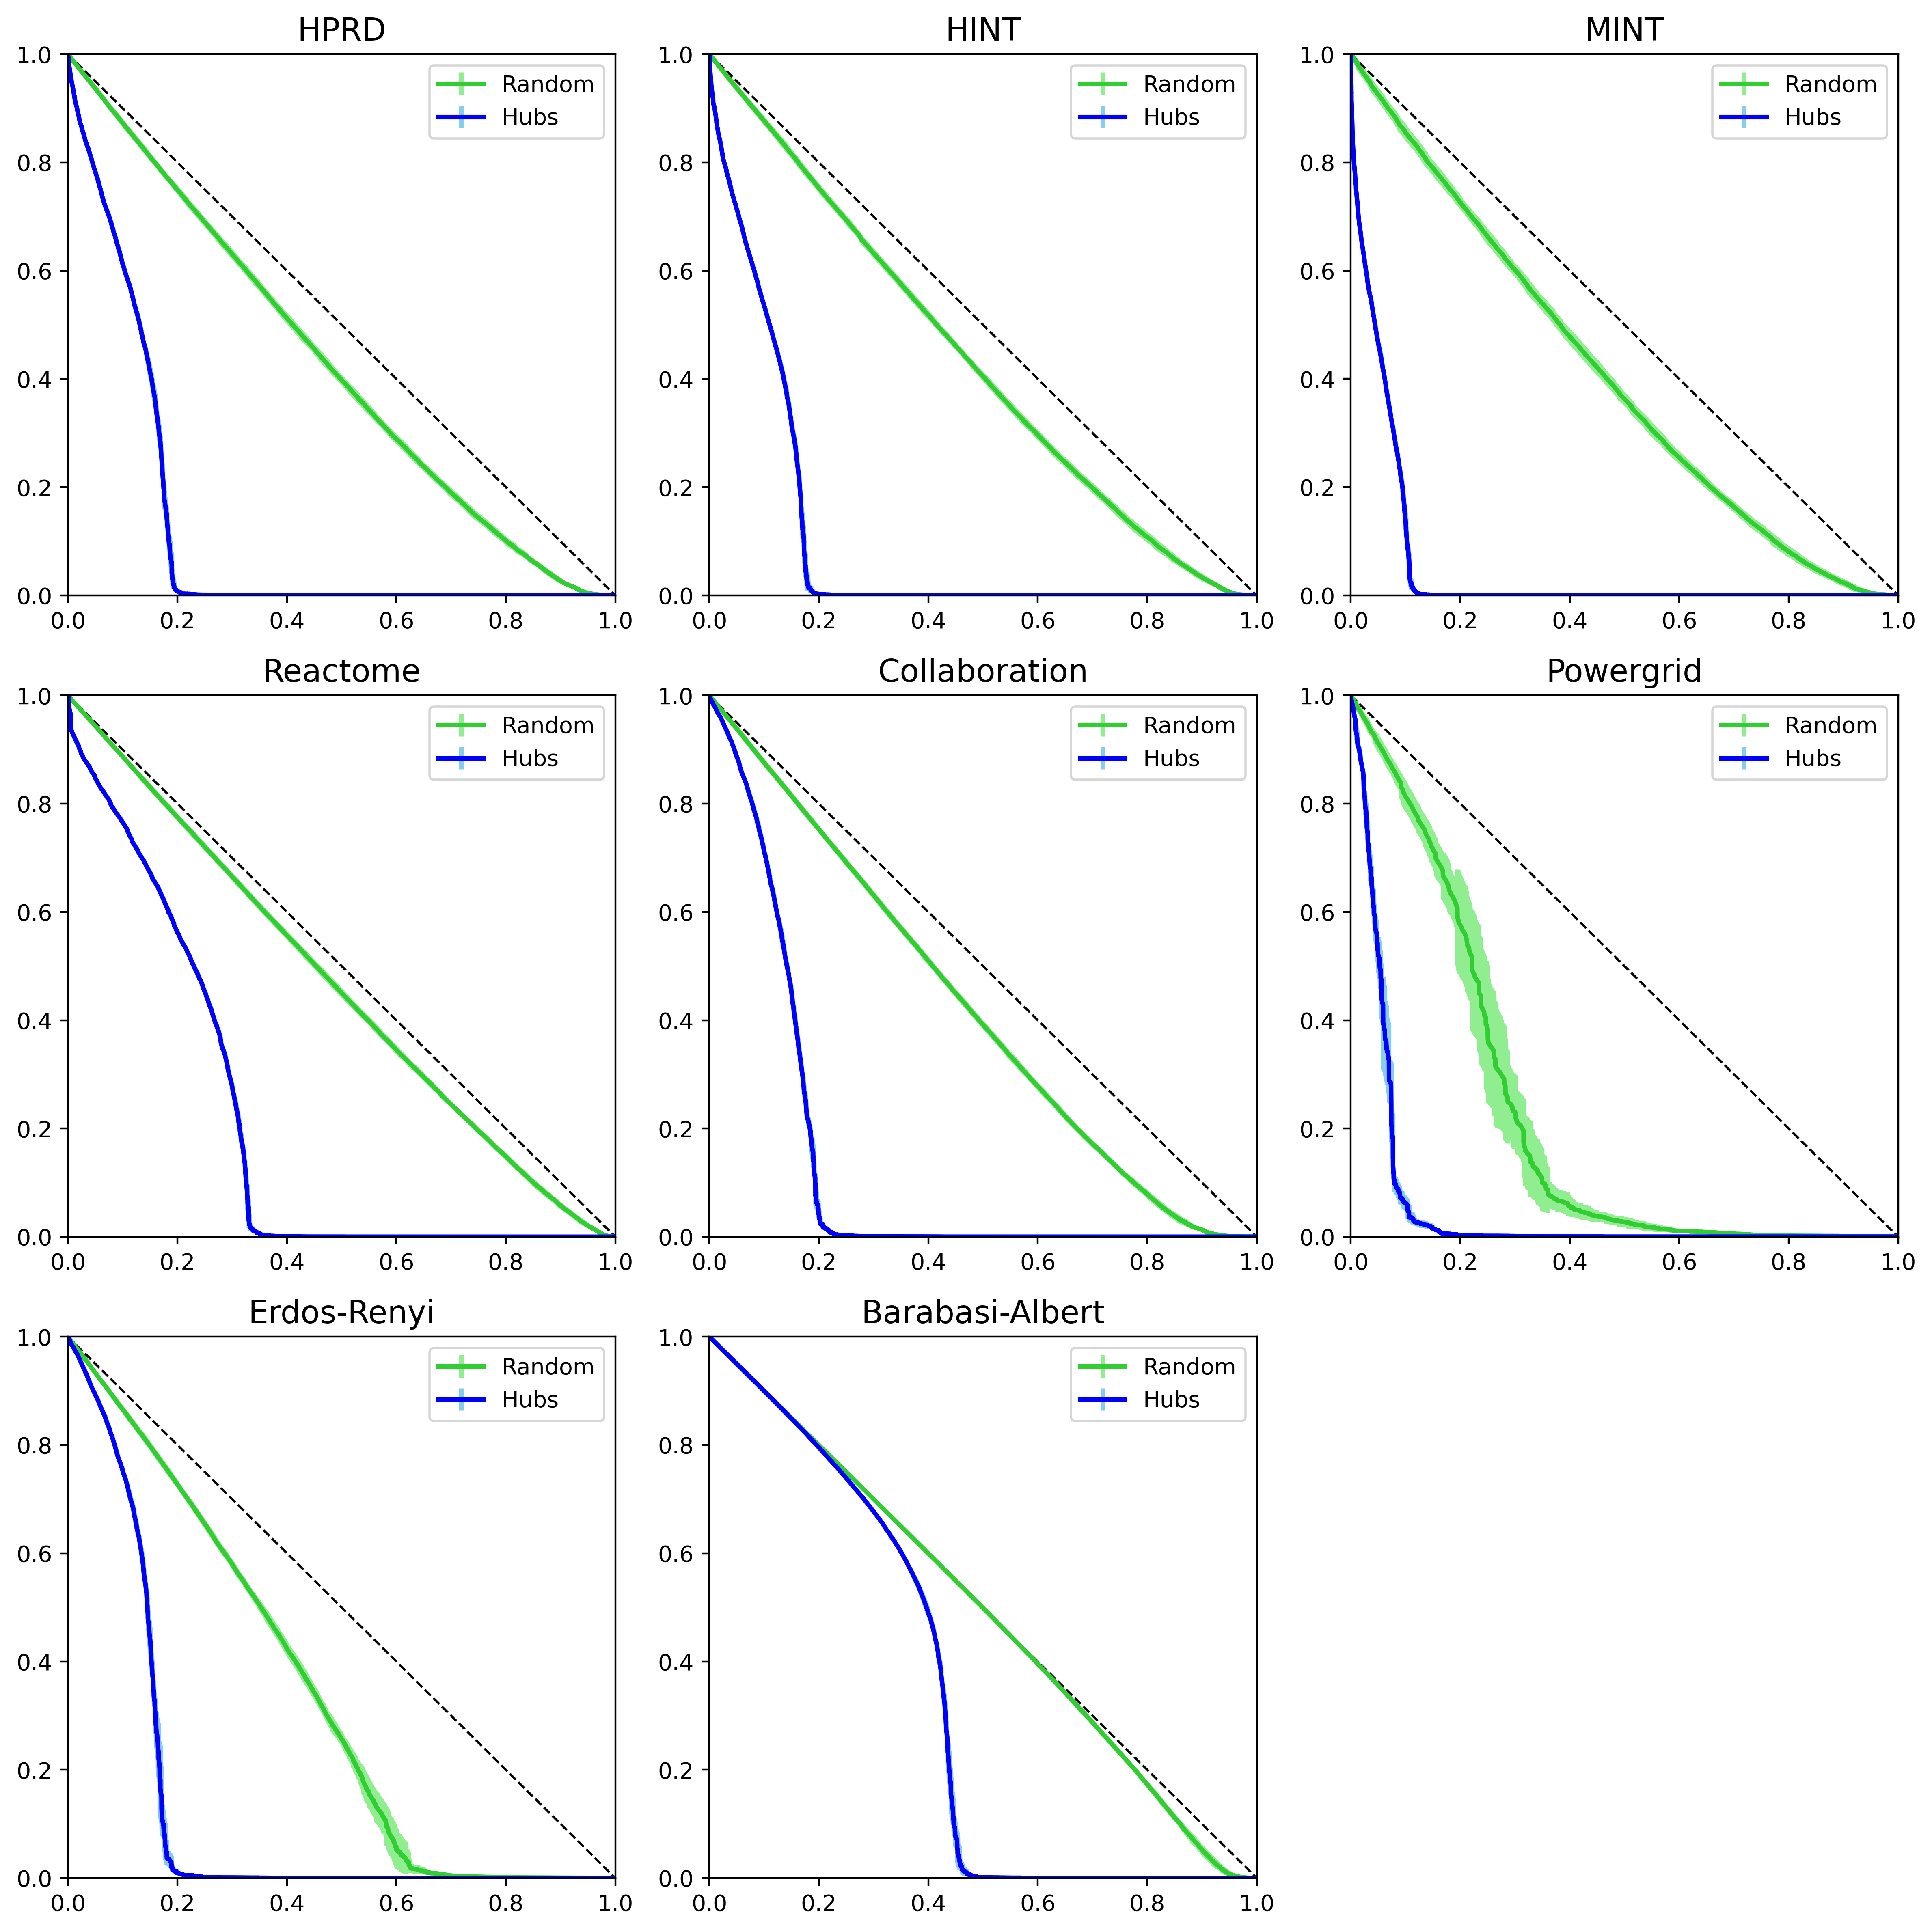

In [4]:
matrizOfImpacts={}
numberAttacksRandom=30
numberAttacksHub=10

plt.figure(figsize=(12,12),dpi=400)
i=1
for name,G in networks.items():
    LCC = nx.subgraph(G,max(nx.connected_components(G)))
    
    matrizOfImpacts[name]={}
    matrizOfImpacts[name]['Hubs']=[]
    matrizOfImpacts[name]['Random']=[]
    
    plt.subplot(3,3,i)
    i+=1
    
    matrizOfImpacts[name]['Random'].append(rd_impact(LCC,numberAttacksRandom))
    print(name+' Random')
    matrizOfImpacts[name]['Hubs'].append(intentional_impact(LCC,numberAttacksHub))
    print(name+' Hubs')
    
    plt.plot([0,1], [1,0], 'k--',linewidth=1)
    plt.margins(x=0)
    plt.margins(y=0)
    plt.title(LCC.name,fontsize=14)
    plt.legend()
    plt.tight_layout()

plt.savefig("ouput/2 Attack.png", format='png', dpi=550)
plt.savefig("ouput/2 Attack.svg", format='svg')
plt.savefig("ouput/2 Attack.pdf", format='pdf')

plt.tight_layout()    
plt.show()

In [5]:
#Save the attacks matrix as a file
with open('ouput/matrizOfImpacts.pickleDict', 'wb') as handle:
    pickle.dump(matrizOfImpacts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
#Open file
with open('ouput/matrizOfImpacts.pickleDict', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [12]:
unserialized_data['HPRD']['Hubs'][0][0]

[array([0.00000000e+00, 1.08471635e-04, 2.16943269e-04, ...,
        9.99783057e-01, 9.99891528e-01, 1.00000000e+00]),
 array([1.00000000e+00, 9.99457642e-01, 9.96637379e-01, ...,
        1.08471635e-04, 1.08471635e-04, 0.00000000e+00])]